In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
# import lux # slows down dataframe processing
import matplotlib.pyplot as plt
%matplotlib inline

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

np.set_printoptions(suppress=True) # do not print scientific notation

# Set some matplotlib style parameters
plt.style.use('seaborn')
plt.rcParams.update({'figure.facecolor' : 'white',
                     'figure.edgecolor' : 'white',
                     'axes.grid'        : True,
                     # 'axes.axisbelow'   : True,
                     'figure.autolayout': True # tight_layout
                    })

# Set some pandas options
pd.set_option('display.max_columns', None, # show x columns (None shows all)
              # 'display.max_rows', None,  # show x rows    (None shows all)
              'compute.use_numba', True)   # turn off for Lux

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
seed = 42
rng = np.random.default_rng(seed)

n = secure_bits = 1         # rows
m = corrected_key_bits = 10 # columns.
N_vec = 10000               # nº of corrected key vectors

## Functions

### Detect power consumption of basic gates

In [4]:
def get_product_power(mat, vec, gate_powers, noise_std=0.):
    '''Returns: array with the power consumed by the gates of each product.
    Set noise_std = 0 to eliminate noise.'''
    n, m = mat.shape
    count = [[] for _ in range(n)]
    for i in range(n):
        for j in range(m):
            idx = 2 * mat[i, j] + vec[j]
            count[i].extend(gate_powers[idx] + rng.normal(scale=noise_std, size=gate_powers[idx].size))
    return count # size = n * m * gate_powers[idx].size

In [5]:
def get_sum_power(mat, vec, gate_powers, noise_std=0.):
    '''Returns: array with the power consumed by the gates of each sum.
    Set noise_std = 0 to eliminate noise.'''
    n, m = mat.shape
    count = [[] for _ in range(n)]
    for i in range(n):
        result = 0
        for j in range(m):
            next_element = mat[i, j] * vec[j]
            idx = 2 * result + next_element
            count[i].extend(gate_powers[idx] + rng.normal(scale=noise_std, size=gate_powers[idx].size))
            result = (result + next_element) % 2
    return count # size = n * m * gate_powers[idx].size

In [6]:
# # TEST
# mat = np.asarray([[0, 1, 1, 0, 1],
#                   [1, 0, 1, 1, 1],
#                   [1, 1, 1, 1, 1],
#                   [0, 0, 0, 0, 0]])
# # vec = np.asarray([0, 0, 0, 0, 0])
# # vec = np.asarray([1, 1, 1, 1, 1])
# vec = np.asarray([1, 1, 1, 0, 0])
# power_products = np.asarray([[.1, 1.1], [.2, 1.2], [.3, 1.3], [.4, 1.4]])
# power_sums = np.asarray([[1.1, 2.1], [1.2, 2.2], [1.3, 2.3], [1.4, 2.4]])

# print(mat @ vec % 2, '\n')
# count = get_product_power(mat, vec, power_products, 0.01)
# print(np.around(count, 3), '\n')
# count = get_sum_power(mat, vec, power_sums, 0.01)
# print(np.around(count, 3))

### Class

In [7]:
# Detect if there are more 1s than 0s
def More_1_than_0(mat, vec):
    return np.sum(mat @ vec % 2) > secure_bits / 2

### Other

In [8]:
# Check if input & output vectors from sample are unique
def Check_uniqueness(mat, vec):
    res = []
    for i in range(len(vec)):
        res.append(mat @ vec[i] % 2)
    unique_in  = np.unique(vec, axis=0)
    unique_out = np.unique(res, axis=0)
    return unique_in.shape[0], unique_out.shape[0]

## Generate data

In [9]:
mat = rng.integers(2, size=(secure_bits,corrected_key_bits), dtype=np.int8)

mat.shape, mat

((1, 10), array([[1, 0, 1, 0, 1, 1, 0, 1, 1, 1]], dtype=int8))

In [10]:
vec = [rng.integers(2, size=corrected_key_bits, dtype=np.int8) for _ in range(N_vec)]

np.shape(vec), vec[0]

((10000, 10), array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0], dtype=int8))

In [9]:
unique_in, unique_out = Check_uniqueness(mat, vec)
print(f'{N_vec} inputs: {unique_in} unique inputs, {unique_out} unique solutions')

10000 inputs: 1024 unique inputs, 2 unique solutions


Assumptions on power consumption (based on https://ieeexplore.ieee.org/document/6644863):
- NOT:
    - 0 - 6.73 pA
    - 1 - 7.45 pA
- 2-input NOR:
    - 00 - 13.50 pA
    - 01 - 12.80 pA
    - 10 - &nbsp; 7.93 pA
    - 11 - &nbsp; 5.93 pA
- 2-input NAND:
    - 00 - &nbsp; 5.79 pA
    - 01 - &nbsp; 7.00 pA
    - 10 - 11.77 pA
    - 11 - 14.91 pA

Writing our operations in the gates above:
- A\*B &nbsp;= AND(A, B)
= NOT(NAND(A, B))

- A+B = XOR(A, B)
= NOT(A<=>B)
= NOT(AND(A->B, B->A))
= NAND(A->B, B->A)
= NAND(OR(NOT(A), B), OR(NOT(B), A)) =  
&nbsp; &nbsp; &nbsp; &nbsp; = NAND(NOT(NOR(NOT(A), B)), NOT(NOR(NOT(B), A)))

Thus:
- 0\*0: &nbsp; &nbsp; 5.79 + 7 = 12.79 pA
- 0\*1: &nbsp; &nbsp; 7.00 + 7 = 14.00 pA
- 1\*0: &nbsp; 11.77 + 7 = 18.77 pA
- 1\*1: &nbsp; 14.91 + 7 = 21.91 pA


- 0+0: &nbsp; (7 + 7.93 + 7) + (7 + 7.93 + 7) + 14.91 = 58.77 pA
- 0+1: &nbsp; (7 + 5.93 + 7) + (7 + 13.5 + 7) + 11.77 = 59.20 pA
- 1+0: &nbsp; (7 + 13.5 + 7) + (7 + 5.93 + 7) + 7 &nbsp; &nbsp; &nbsp; &nbsp;= 54.43 pA
- 1+1: &nbsp; (7 + 12.8 + 7) + (7 + 12.8 + 7) + 14.91 = 68.51 pA

In [11]:
# Define power consumption for each gate & noise level
power_product_gates = np.asarray([[5.79, 7.45], [7., 7.45], [11.77, 7.45], [14.91, 6.73]]) # 0*0, 0*1, 1*0, 1*1
power_sum_gates = np.asarray([[6.73, 6.73, 7.93, 7.93, 6.73, 6.73, 14.91],  # '0+0' gates
                              [6.73, 7.45, 5.93, 13.5, 6.73, 7.45, 11.77],  # '0+1' gates
                              [7.45, 6.73, 13.5, 5.93, 7.45, 6.73, 7.],     # '1+0' gates
                              [7.45, 7.45, 12.8, 12.8, 6.73, 6.73, 14.91]]) # '1+1' gates
noise_std = 0.05 + 0.5 # article measurement precision + hacker device noise

In [11]:
i = 0
print('Products:\n', np.around(get_product_power(mat, vec[i], power_product_gates, noise_std), 3))
print('Sums:\n', np.around(get_sum_power(mat, vec[i], power_sum_gates, noise_std), 3))

Products:
 [[11.952  6.775  6.765  6.89  11.956  7.309  5.553  7.87  11.904  7.732
  11.321  7.354  6.577  7.341 11.705  8.464 14.767  5.561 12.537  7.697]]
Sums:
 [[ 6.658  6.49   7.409  8.996  6.759  5.774 15.09   7.393  6.816  7.434
   7.385  6.225  7.567 14.871  5.807  6.941  8.008  7.683  6.169  6.145
  15.508  6.866  6.993  8.065  8.11   6.472  6.617 15.551  7.508  6.058
   7.815  8.392  7.765  7.71  14.472  7.431  6.762  8.504  8.364  6.035
   7.032 15.463  6.719  6.595  7.066  8.306  6.845  6.223 14.731  6.815
   6.423  7.931  6.968  7.472  6.739 14.305  5.377  8.016  6.237 13.616
   7.205  7.923 11.877  7.31   6.501 13.732  6.698  7.393  7.542  7.205]]


In [12]:
print("#1 > #0?")
print("--------")
for i in range(10):
    print(More_1_than_0(mat, vec[i]), '\t', mat @ vec[i] % 2)

#1 > #0?
--------
True 	 [1]
True 	 [1]
False 	 [0]
False 	 [0]
True 	 [1]
True 	 [1]
False 	 [0]
True 	 [1]
False 	 [0]
False 	 [0]


In [12]:
# Order data by time (row by row)
data = [[] for _ in range(N_vec)]
for i in range(N_vec):
    product_power = get_product_power(mat, vec[i], power_product_gates, noise_std)
    sum_power     = get_sum_power(mat, vec[i], power_sum_gates, noise_std)
    for j in range(n):
        data[i].extend(product_power[j])
        data[i].extend(sum_power[j])
    data[i].append(More_1_than_0(mat, vec[i]))

data = np.asarray(data)
class_index = data.shape[1] - 1
data.shape

(10000, 91)

In [13]:
# Create dataframe for plotting raw data
df_raw = pd.DataFrame(data).astype({class_index: bool})
df_raw.drop_duplicates(inplace=True, ignore_index=True)
np.around(df_raw, 3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,11.952,6.775,6.765,6.890,11.956,7.309,5.553,7.870,11.904,7.732,11.321,7.354,6.577,7.341,11.705,8.464,14.767,5.561,12.537,7.697,6.658,6.490,7.409,8.996,6.759,5.774,15.090,7.393,6.816,7.434,7.385,6.225,7.567,14.871,5.807,6.941,8.008,7.683,6.169,6.145,15.508,6.866,6.993,8.065,8.110,6.472,6.617,15.551,7.508,6.058,7.815,8.392,7.765,7.710,14.472,7.431,6.762,8.504,8.364,6.035,7.032,15.463,6.719,6.595,7.066,8.306,6.845,6.223,14.731,6.815,6.423,7.931,6.968,7.472,6.739,14.305,5.377,8.016,6.237,13.616,7.205,7.923,11.877,7.310,6.501,13.732,6.698,7.393,7.542,7.205,True
1,15.119,8.053,7.909,8.373,11.331,8.656,5.745,7.325,10.582,7.629,14.314,6.955,6.361,8.439,15.213,7.984,14.347,7.582,13.919,6.844,6.383,7.204,5.646,12.997,6.037,7.207,11.834,8.090,6.892,14.142,5.117,7.212,7.121,7.189,6.976,7.244,13.208,5.502,7.718,6.733,6.712,7.144,6.142,13.282,6.535,7.585,7.257,7.284,7.113,5.823,12.990,5.561,7.038,7.270,7.534,8.667,7.030,13.679,13.675,6.602,6.990,15.592,6.698,6.655,7.585,6.632,6.769,6.340,14.319,6.962,6.652,6.373,13.766,6.510,7.415,11.115,7.863,7.553,12.944,13.076,6.377,5.895,15.437,7.109,7.156,6.155,14.192,7.356,7.139,10.951,True
2,14.186,6.559,6.594,7.049,11.442,7.111,5.498,7.444,14.206,7.326,11.690,8.814,6.355,8.324,15.675,6.504,14.693,6.223,11.270,7.450,6.741,6.569,7.191,13.357,6.766,7.106,11.623,7.253,6.728,13.492,6.373,7.575,7.117,6.995,7.577,6.597,14.052,6.107,7.363,6.627,6.940,7.467,6.699,13.193,6.351,7.905,7.711,6.668,7.817,6.400,13.256,11.999,6.189,6.913,14.568,6.313,6.463,8.331,7.417,6.700,6.522,15.361,7.196,5.721,8.505,7.594,6.860,6.214,15.114,8.133,7.520,5.677,13.372,5.922,8.247,11.942,6.873,6.891,12.808,13.313,6.097,7.342,14.860,6.218,6.473,8.892,7.166,6.327,7.254,15.029,False
3,11.335,7.981,6.347,7.632,11.433,7.198,7.157,6.728,12.500,8.385,11.640,7.646,7.652,8.526,15.766,5.775,11.596,7.725,14.638,7.711,7.626,6.281,7.841,7.518,6.623,6.606,15.435,6.241,5.291,7.048,7.364,6.369,6.833,14.316,6.064,6.219,7.316,7.625,6.401,7.109,14.366,6.533,6.430,8.375,7.845,7.308,6.096,14.883,6.413,6.056,7.893,8.883,6.261,6.660,14.188,5.927,6.297,7.683,7.707,6.606,5.823,14.566,7.006,5.983,7.735,8.091,6.300,6.918,14.073,7.219,7.651,5.961,14.119,6.549,7.110,12.525,8.462,6.349,13.437,6.505,7.407,7.057,7.429,7.141,7.681,12.797,12.131,6.186,6.371,15.421,False
4,15.439,7.142,7.242,7.677,11.923,7.674,7.261,6.678,11.335,6.884,15.519,7.640,4.597,8.311,14.958,7.287,12.049,8.242,11.885,6.700,6.672,7.734,5.811,13.862,6.694,7.122,11.173,7.235,6.843,12.422,5.501,6.352,6.391,7.659,6.798,7.117,15.067,6.729,7.523,7.202,6.247,6.585,6.746,13.719,6.532,7.137,6.836,7.088,7.378,6.690,13.030,6.084,7.557,6.488,7.366,8.015,7.823,12.227,12.855,6.229,6.783,14.411,7.432,7.161,8.564,8.508,6.581,6.496,15.868,6.639,6.705,6.484,13.579,7.558,7.584,11.759,8.289,5.884,13.178,5.442,6.243,7.210,6.693,7.948,6.944,13.834,5.680,7.030,6.779,7.506,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,14.590,6.516,6.235,8.376,15.692,6.087,5.928,7.719,12.264,8.192,12.088,7.651,6.103,7.742,13.825,6.781,14.963,6.082,15.970,6.534,7.214,7.863,5.698,13.776,5.400,7.438,11.564,7.729,6.567,13.892,5.277,8.446,6.795,7.266,7.718,7.070,13.408,12.622,7.379,6.316,13.026,5.887,6.316,8.185,8.503,7.111,6.788,15.369,6.168,7.465,8.009,8.319,7.921,6.352,15.122,6.696,7.006,8.443,7.971,7.398,7.492,14.083,7.293,5.682,7.828,8.148,6.572,7.163,15.144,7.053,7.455,5.276,13.957,6.984,7.361,11.492,7.271,7.411,13.005,12.605,6.644,6.294,14.980,

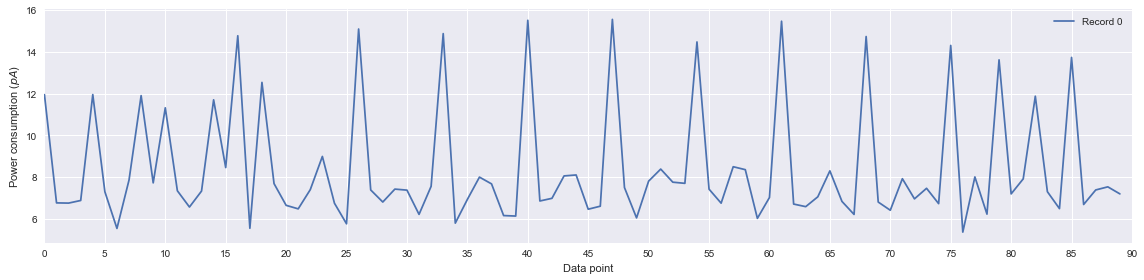

In [14]:
# Plot power consumption through time
y = df_raw.iloc[0][:-1]
X = np.arange(len(y))

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
# plt.ylim(y.min()*0.95, y.max()*1.05)
plt.xticks(np.arange(0, len(y)+1, 5))
# plt.yticks(np.arange(6, 16, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
# plt.title('Power consumption', fontsize=14)

# plt.savefig('Results/plot_y.png', dpi=200)
plt.show()

In [15]:
# Create centered dataframe
data[:, :-1] -= data[:, :-1].mean(axis=1, keepdims=True)

df = pd.DataFrame(data).astype({class_index: bool})
df.drop_duplicates(inplace=True, ignore_index=True)
np.around(df, 3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,3.542,-1.635,-1.645,-1.520,3.546,-1.101,-2.857,-0.540,3.494,-0.678,2.911,-1.056,-1.833,-1.070,3.295,0.054,6.357,-2.849,4.127,-0.713,-1.752,-1.921,-1.001,0.586,-1.652,-2.636,6.680,-1.017,-1.594,-0.976,-1.025,-2.185,-0.843,6.460,-2.603,-1.469,-0.403,-0.727,-2.241,-2.265,7.097,-1.544,-1.417,-0.346,-0.300,-1.938,-1.793,7.141,-0.902,-2.352,-0.595,-0.019,-0.645,-0.700,6.062,-0.979,-1.648,0.094,-0.047,-2.375,-1.378,7.053,-1.691,-1.816,-1.345,-0.104,-1.565,-2.187,6.321,-1.595,-1.987,-0.479,-1.443,-0.938,-1.671,5.895,-3.033,-0.394,-2.173,5.206,-1.205,-0.487,3.467,-1.100,-1.910,5.321,-1.712,-1.017,-0.868,-1.205,True
1,6.412,-0.654,-0.798,-0.334,2.624,-0.051,-2.962,-1.382,1.875,-1.078,5.607,-1.752,-2.346,-0.268,6.506,-0.723,5.640,-1.125,5.212,-1.863,-2.324,-1.503,-3.061,4.290,-2.670,-1.500,3.127,-0.617,-1.815,5.435,-3.590,-1.495,-1.586,-1.518,-1.731,-1.463,4.501,-3.205,-0.989,-1.974,-1.995,-1.563,-2.565,4.575,-2.172,-1.122,-1.450,-1.423,-1.594,-2.884,4.283,-3.146,-1.669,-1.437,-1.173,-0.040,-1.677,4.972,4.968,-2.105,-1.717,6.885,-2.009,-2.052,-1.122,-2.075,-1.938,-2.367,5.612,-1.745,-2.055,-2.334,5.059,-2.197,-1.292,2.408,-0.844,-1.154,4.237,4.369,-2.330,-2.812,6.730,-1.598,-1.551,-2.552,5.485,-1.351,-1.567,2.244,True
2,5.537,-2.090,-2.054,-1.599,2.794,-1.538,-3.151,-1.205,5.557,-1.322,3.042,0.165,-2.294,-0.324,7.027,-2.145,6.044,-2.425,2.621,-1.199,-1.907,-2.080,-1.457,4.709,-1.882,-1.543,2.975,-1.395,-1.920,4.843,-2.276,-1.074,-1.531,-1.654,-1.071,-2.051,5.403,-2.541,-1.285,-2.022,-1.709,-1.182,-1.949,4.544,-2.298,-0.743,-0.937,-1.980,-0.832,-2.249,4.607,3.350,-2.460,-1.736,5.920,-2.336,-2.185,-0.317,-1.232,-1.948,-2.127,6.712,-1.452,-2.928,-0.144,-1.054,-1.789,-2.435,6.466,-0.515,-1.129,-2.971,4.724,-2.726,-0.402,3.294,-1.775,-1.757,4.160,4.664,-2.552,-1.306,6.211,-2.430,-2.176,0.243,-1.482,-2.321,-1.395,6.381,False
3,2.869,-0.485,-2.119,-0.833,2.968,-1.268,-1.309,-1.737,4.035,-0.081,3.175,-0.820,-0.813,0.060,7.301,-2.690,3.131,-0.740,6.173,-0.755,-0.839,-2.184,-0.625,-0.948,-1.843,-1.860,6.969,-2.224,-3.175,-1.418,-1.101,-2.096,-1.633,5.850,-2.402,-2.247,-1.149,-0.841,-2.064,-1.357,5.900,-1.932,-2.035,-0.091,-0.621,-1.158,-2.369,6.417,-2.052,-2.410,-0.573,0.417,-2.205,-1.806,5.723,-2.538,-2.169,-0.783,-0.759,-1.860,-2.642,6.100,-1.460,-2.483,-0.731,-0.375,-2.166,-1.548,5.608,-1.247,-0.814,-2.505,5.653,-1.917,-1.355,4.059,-0.003,-2.117,4.972,-1.961,-1.059,-1.409,-1.036,-1.325,-0.785,4.331,3.665,-2.280,-2.094,6.955,False
4,6.975,-1.321,-1.222,-0.787,3.459,-0.790,-1.202,-1.786,2.871,-1.580,7.055,-0.824,-3.867,-0.153,6.494,-1.177,3.585,-0.222,3.421,-1.764,-1.792,-0.730,-2.653,5.398,-1.770,-1.341,2.709,-1.229,-1.621,3.958,-2.963,-2.112,-2.073,-0.805,-1.666,-1.347,6.603,-1.734,-0.940,-1.262,-2.217,-1.879,-1.718,5.255,-1.932,-1.327,-1.628,-1.376,-1.086,-1.774,4.566,-2.380,-0.907,-1.976,-1.098,-0.449,-0.641,3.763,4.391,-2.235,-1.681,5.947,-1.031,-1.303,0.100,0.045,-1.883,-1.968,7.404,-1.825,-1.759,-1.980,5.115,-0.906,-0.880,3.295,-0.175,-2.580,4.714,-3.022,-2.221,-1.254,-1.770,-0.516,-1.520,5.370,-2.784,-1.434,-1.685,-0.958,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5.761,-2.313,-2.594,-0.452,6.864,-2.741,-2.901,-1.110,3.436,-0.636,3.260,-1.178,-2.725,-1.086,4.997,-2.048,6.135,-2.746,7.141,-2.294,-1.615,-0.966,-3.131,4.947,-3.429,-1.390,2.736,-1.100,-2.261,5.064,-3.551,-0.382,-2.034,-1.562,-1.110,-1.758,4.580,3.794,-1.450,-2.512,4.198,-2.942,-2.512,-0.

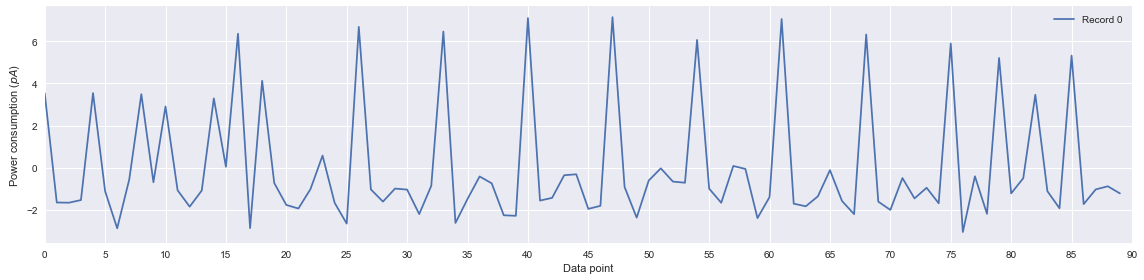

In [16]:
# Plot centered data: power consumption through time
y = df.iloc[0][:-1]
X = np.arange(len(y))

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
# plt.ylim(y.min()*1.05, y.max()*1.05)
plt.xticks(np.arange(0, len(y)+1, 5))
# plt.yticks(np.arange(-2, 6, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
# plt.title('Power consumption', fontsize=14)

# plt.savefig('Results/plot_y.png', dpi=200)
plt.show()

In [18]:
# # Drop columns with equal values (worthless with noise)
# def duplicate_columns(df):
#     groups = df.columns.to_series().groupby(df.dtypes).groups
#     dups = []
#     for t, v in groups.items():
#         dcols = df[v].to_dict(orient='list')
#         vs = list(dcols.values())
#         ks = list(dcols.keys())
#         for i in range(len(vs)):
#             for j in range(i+1, len(vs)):
#                 if vs[i] == vs[j]: 
#                     dups.append(ks[i])
#                     break
#     if dups: print('Duplicate columns:', *dups)
#     return dups

# df.drop(duplicate_columns(df), axis=1, inplace=True)
# np.around(df, 3)

In [19]:
# # Check some trends in data (turn off numba engine first)
# pd.set_option('compute.use_numba', False)
# df2 = df.copy()
# df2.intent = [90] # More_1_than_0
# display(df2)
# pd.set_option('compute.use_numba', True)

In [486]:
# Generate pandas profiling report
profile = ProfileReport(df, title=f'More_1s_or_0s Noisy_Power_per_Gate noise_std={noise_std} Dataset Report', explorative=True)
# profile.to_widgets()
profile.to_file(f'Docs/More_1s_or_0s_-_Noisy_Power_per_Gate_noisestd={noise_std}_report.html')

Summarize dataset:   0%|          | 0/161 [00:00<?, ?it/s]

C:\Users\V082335\Anaconda3\lib\site-packages\pandas\core\series.py:1441: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Split data

In [18]:
# Split data into training & test set
X_raw = np.asarray(df_raw.drop(class_index, axis=1), order='C')
y_raw = np.asarray(df_raw[class_index], order='C')
X = np.asarray(df.drop(class_index, axis=1), order='C')
y = np.asarray(df[class_index], order='C')

assert X_raw.flags['C_CONTIGUOUS']
assert y_raw.flags['C_CONTIGUOUS']
assert X.flags['C_CONTIGUOUS']
assert y.flags['C_CONTIGUOUS']

# X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=seed) # used before cross-val

## Classifiers

### Logs

###### Noise std. dev. <= 0.5
Models able to to predict with ~100% accuracy:
- Logistic regression
- All SVM
- Gaussian, Categorical Naïve Bayes
- Decision tree

Models which comparatively suck:
- Multinomial Naïve Bayes

###### Noise std. dev. = 1
Models able to to predict with ~100% accuracy:
- Logistic regression
- All SVM
- Decision tree

Models which comparatively suck:
- All Naïve Bayes

###### Noise std. dev. = 2
Models able to to predict with 90% < accuracy < 97%:
- Logistic regression
- All SVM
- Decision tree

Models which comparatively suck:
- Gaussian Naïve Bayes

###### Noise std. dev. = 5
Best accuracy: ~72%

### Functions to train & test models

In [21]:
# Train model with stratified k-fold cross-validation & get statistics
def Train_stratCV(model, X, y, n_splits=5, seed=seed):
    skf = StratifiedKFold(n_splits, shuffle=True, random_state=seed)
    lst_acc = []
    lst_y_pred = [] # not used yet

    # Train & test each fold
    for train_idx, test_idx in skf.split(X, y):
        x_train_fold, x_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        model.fit(x_train_fold, y_train_fold)
        lst_acc.append(model.score(x_test_fold, y_test_fold))
        lst_y_pred.append(model.predict(x_test_fold))

    # print(f'\nList of accuracies: {lst_acc}')
    print(f'\nMin/max accuracy:   {min(lst_acc):.2%} <---> {max(lst_acc):.2%}')
    print(f'Mean accuracy:      {np.mean(lst_acc):.2%} +- {np.std(lst_acc):.3%}')
    
    # add more stats
    
    return lst_acc, lst_y_pred

# accuracy_score(y_test, y_pred) # how often is the classifier correct?
# confusion_matrix(y_test, y_pred, normalize='pred') # precision
# confusion_matrix(y_test, y_pred, normalize='true') # recall
# classification_report(y_test, y_pred, output_dict=True)

In [22]:
# Test different parameters
    # ***** use grid search
def test_eta0(model, low, up, Xs, ys, seed):
    best_eta0, best_acc = 0., 0.
    best_X = 0
    
    for j, (X, y) in enumerate(zip(Xs, ys)):
        print(f'\n---> X{j}, y{j}')
        for i in range(low, up):
            model.eta0 = 10.**i
            model.verbose = 0
            acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
            print(f'eta0 = {model.eta0:.0e}')
            
            current_acc = np.mean(acc_strat)
            if current_acc > best_acc:
                best_eta0 = model.eta0
                best_acc = current_acc
                best_X = j
    print(f'\nBest accuracy: {best_acc:.2%} ---> X{best_X} with eta0 = {best_eta0:.0e}')

def test_coef0(model, low, up, Xs, ys, seed):
    best_coef0, best_acc = 0., 0.
    best_X = 0
    
    for j, (X, y) in enumerate(zip(Xs, ys)):
        print(f'\n---> X{j}, y{j}')
        for i in np.arange(low, up, 1):
            model.coef0 = i
            model.verbose = 0
            acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
            print(f'coef0 = {model.coef0}')
            
            current_acc = np.mean(acc_strat)
            if current_acc > best_acc:
                best_coef0 = model.coef0
                best_acc = current_acc
                best_X = j
    print(f'\nBest accuracy: {best_acc:.2%} ---> X{best_X} with coef0 = {best_coef0}')

def test_trees(model, Xs, ys, seed, max_depth=[None], max_features=[None], max_leaf_nodes=[None], min_impurity_decrease=[0.]):
    best_par = []
    best_acc = 0.
    best_X = 0
    for j, (X, y) in enumerate(zip(Xs, ys)):
        print(f'\n---> X{j}, y{j}')
        for md in max_depth:
            model.max_depth = md
            for mf in max_features:
                model.max_features = mf
                for mln in max_leaf_nodes:
                    model.max_leaf_nodes = mln
                    for mid in min_impurity_decrease:
                        model.min_impurity_decrease = mid
                        acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
                        print(f'{md}, {mf}, {mln}, {mid:.0e}')
            
                        current_acc = np.mean(acc_strat)
                        if current_acc > best_acc:
                            best_par = md, mf, mln, mid
                            best_acc = current_acc
                            best_X = j
    print(f'\nBest accuracy with X{best_X}:  {best_acc:.2%}\n'
          f'max_depth             = {best_par[0]}\n'
          f'max_features          = {best_par[1]}\n'
          f'max_leaf_nodes        = {best_par[2]}\n'
          f'min_impurity_decrease = {best_par[3]:.0e}')

### Logistic regression

In [22]:
model = SGDClassifier(loss='log', learning_rate='adaptive', eta0=1e-1, tol=1e-5, max_iter=1e4, n_jobs=-1, random_state=seed,
                      verbose=-1)
test_eta0(model, -6, 7, [X, X_raw], [y, y_raw], seed)
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


---> X0, y0

Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%
eta0 = 1e-06

Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%
eta0 = 1e-05

Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%
eta0 = 1e-04

Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%
eta0 = 1e-03

Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%
eta0 = 1e-02

Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%
eta0 = 1e-01

Min/max accuracy:   99.95% <---> 100.00%
Mean accuracy:      99.99% +- 0.020%
eta0 = 1e+00

Min/max accuracy:   99.80% <---> 100.00%
Mean accuracy:      99.90% +- 0.071%
eta0 = 1e+01

Min/max accuracy:   97.90% <---> 98.85%
Mean accuracy:      98.47% +- 0.325%
eta0 = 1e+02

Min/max accuracy:   97.80% <---> 98.90%
Mean accuracy:      98.30% +- 0.351%
eta0 = 1e+03

Min/max accuracy:   97.80% <---> 98.50%
Mean accuracy:  

In [306]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### SVM

#### Linear kernel

In [20]:
model = SVC(kernel='linear', probability=False, tol=1e-5, max_iter=-1, cache_size=1000, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
print()
acc_strat, y_pred = Train_stratCV(model, X_raw, y_raw, 5, seed)

NameError: name 'Train_stratCV' is not defined

In [ ]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

In [21]:
model = SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=1e4, tol=1e-5, max_iter=1e4, n_jobs=-1, random_state=seed,
                      verbose=-1)
test_eta0(model, -6, 7, [X, X_raw], [y, y_raw], seed)
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


---> X0

List of accuracies: [0.6855, 0.693, 0.7155, 0.6905, 0.695]
Min/max accuracy:   68.55% <---> 71.55%
Mean accuracy:      69.59% +- 1.030%
eta0 = 1e-06

List of accuracies: [0.6805, 0.6935, 0.716, 0.6925, 0.696]
Min/max accuracy:   68.05% <---> 71.60%
Mean accuracy:      69.57% +- 1.147%
eta0 = 1e-05

List of accuracies: [0.685, 0.696, 0.7125, 0.695, 0.6985]
Min/max accuracy:   68.50% <---> 71.25%
Mean accuracy:      69.74% +- 0.884%
eta0 = 1e-04

List of accuracies: [0.688, 0.6995, 0.7085, 0.697, 0.699]
Min/max accuracy:   68.80% <---> 70.85%
Mean accuracy:      69.84% +- 0.654%
eta0 = 1e-03

List of accuracies: [0.6835, 0.698, 0.7, 0.6935, 0.699]
Min/max accuracy:   68.35% <---> 70.00%
Mean accuracy:      69.48% +- 0.607%
eta0 = 1e-02

List of accuracies: [0.685, 0.7045, 0.7035, 0.6935, 0.6985]
Min/max accuracy:   68.50% <---> 70.45%
Mean accuracy:      69.70% +- 0.717%
eta0 = 1e-01

List of accuracies: [0.6845, 0.6985, 0.7015, 0.6925, 0.6955]
Min/max accuracy:   68.45% <---> 

In [310]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

In [24]:
model = LinearSVC(loss='squared_hinge', dual=False, tol=1e-5, max_iter=1e4, random_state=seed, verbose=1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
print()
acc_strat, y_pred = Train_stratCV(model, X_raw, y_raw, 5, seed)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [312]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Gaussian kernel

In [37]:
model = SVC(kernel='rbf', gamma='scale', probability=False, tol=1e-5, max_iter=-1, cache_size=1000, random_state=seed,
            verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
print()
acc_strat, y_pred = Train_stratCV(model, X_raw, y_raw, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.7175, 0.728, 0.7255, 0.7195, 0.708]
Min/max accuracy:   70.80% <---> 72.80%
Mean accuracy:      71.97% +- 0.699%

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.716, 0.7285, 0.7275, 0.7155, 0.7135]
Min/max accuracy:   71.35% <---> 72.85%
Mean accuracy:      72.02% +- 0.643%


In [38]:
model = SVC(kernel='rbf', gamma='auto', probability=False, tol=1e-5, max_iter=-1, cache_size=1000, random_state=seed,
            verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
print()
acc_strat, y_pred = Train_stratCV(model, X_raw, y_raw, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.5055, 0.5055, 0.5055, 0.506, 0.506]
Min/max accuracy:   50.55% <---> 50.60%
Mean accuracy:      50.57% +- 0.024%

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.5055, 0.5055, 0.5055, 0.506, 0.506]
Min/max accuracy:   50.55% <---> 50.60%
Mean accuracy:      50.57% +- 0.024%


In [315]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Polynomial kernel

In [33]:
model = SVC(kernel='poly', degree=3, coef0=1., probability=False, tol=1e-5, max_iter=-1, cache_size=1000, random_state=seed,
            verbose=True)
test_coef0(model, -1, 2, [X], [y], seed)
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


---> X0

List of accuracies: [0.5855, 0.6005, 0.5855, 0.59, 0.6065]
Min/max accuracy:   58.55% <---> 60.65%
Mean accuracy:      59.36% +- 0.846%
coef0 = -1

List of accuracies: [0.7095, 0.7145, 0.714, 0.7105, 0.71]
Min/max accuracy:   70.95% <---> 71.45%
Mean accuracy:      71.17% +- 0.211%
coef0 = 0

List of accuracies: [0.692, 0.681, 0.688, 0.6745, 0.676]
Min/max accuracy:   67.45% <---> 69.20%
Mean accuracy:      68.23% +- 0.676%
coef0 = 1

---> X1

List of accuracies: [0.643, 0.6465, 0.6365, 0.638, 0.6345]
Min/max accuracy:   63.45% <---> 64.65%
Mean accuracy:      63.97% +- 0.441%
coef0 = -1

List of accuracies: [0.68, 0.666, 0.689, 0.657, 0.6635]
Min/max accuracy:   65.70% <---> 68.90%
Mean accuracy:      67.11% +- 1.168%
coef0 = 0

List of accuracies: [0.6765, 0.6645, 0.679, 0.653, 0.662]
Min/max accuracy:   65.30% <---> 67.90%
Mean accuracy:      66.70% +- 0.961%
coef0 = 1


In [34]:
model = SVC(kernel='poly', degree=4, coef0=1., probability=False, tol=1e-5, max_iter=-1, cache_size=1000, random_state=seed,
            verbose=True)
test_coef0(model, -1, 2, [X], [y], seed)
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


---> X0

List of accuracies: [0.439, 0.4275, 0.437, 0.435, 0.4525]
Min/max accuracy:   42.75% <---> 45.25%
Mean accuracy:      43.82% +- 0.814%
coef0 = -1

List of accuracies: [0.708, 0.705, 0.7055, 0.7005, 0.6985]
Min/max accuracy:   69.85% <---> 70.80%
Mean accuracy:      70.35% +- 0.348%
coef0 = 0

List of accuracies: [0.683, 0.674, 0.691, 0.6775, 0.661]
Min/max accuracy:   66.10% <---> 69.10%
Mean accuracy:      67.73% +- 0.997%
coef0 = 1

---> X1

List of accuracies: [0.611, 0.602, 0.6085, 0.605, 0.6015]
Min/max accuracy:   60.15% <---> 61.10%
Mean accuracy:      60.56% +- 0.368%
coef0 = -1

List of accuracies: [0.6725, 0.6645, 0.681, 0.6425, 0.6505]
Min/max accuracy:   64.25% <---> 68.10%
Mean accuracy:      66.22% +- 1.407%
coef0 = 0

List of accuracies: [0.665, 0.66, 0.675, 0.6365, 0.65]
Min/max accuracy:   63.65% <---> 67.50%
Mean accuracy:      65.73% +- 1.316%
coef0 = 1


In [318]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Sigmoid kernel

In [35]:
model = SVC(kernel='sigmoid', gamma='scale', coef0=-1., probability=False, tol=1e-5, max_iter=-1, cache_size=1000,
            random_state=seed, verbose=True)
test_coef0(model, -1, 2, [X, X_raw], [y, y_raw], seed)
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


---> X0

List of accuracies: [0.7155, 0.73, 0.7265, 0.713, 0.7105]
Min/max accuracy:   71.05% <---> 73.00%
Mean accuracy:      71.91% +- 0.772%
coef0 = -1

List of accuracies: [0.668, 0.686, 0.6845, 0.671, 0.679]
Min/max accuracy:   66.80% <---> 68.60%
Mean accuracy:      67.77% +- 0.715%
coef0 = 0

List of accuracies: [0.6385, 0.66, 0.655, 0.657, 0.6645]
Min/max accuracy:   63.85% <---> 66.45%
Mean accuracy:      65.50% +- 0.885%
coef0 = 1

---> X1

List of accuracies: [0.553, 0.5535, 0.5735, 0.565, 0.564]
Min/max accuracy:   55.30% <---> 57.35%
Mean accuracy:      56.18% +- 0.772%
coef0 = -1

List of accuracies: [0.555, 0.5565, 0.577, 0.567, 0.5665]
Min/max accuracy:   55.50% <---> 57.70%
Mean accuracy:      56.44% +- 0.801%
coef0 = 0

List of accuracies: [0.61, 0.6035, 0.6135, 0.5955, 0.602]
Min/max accuracy:   59.55% <---> 61.35%
Mean accuracy:      60.49% +- 0.630%
coef0 = 1


In [36]:
model = SVC(kernel='sigmoid', gamma='auto', coef0=-1., probability=False, tol=1e-5, max_iter=-1, cache_size=1000,
            random_state=seed, verbose=True)
test_coef0(model, -1, 2, [X, X_raw], [y, y_raw], seed)
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


---> X0

List of accuracies: [0.546, 0.5465, 0.564, 0.5135, 0.513]
Min/max accuracy:   51.30% <---> 56.40%
Mean accuracy:      53.66% +- 2.014%
coef0 = -1

List of accuracies: [0.5035, 0.5135, 0.553, 0.504, 0.4945]
Min/max accuracy:   49.45% <---> 55.30%
Mean accuracy:      51.37% +- 2.055%
coef0 = 0

List of accuracies: [0.4945, 0.51, 0.501, 0.4995, 0.4885]
Min/max accuracy:   48.85% <---> 51.00%
Mean accuracy:      49.87% +- 0.715%
coef0 = 1

---> X1

List of accuracies: [0.5055, 0.5055, 0.5055, 0.506, 0.506]
Min/max accuracy:   50.55% <---> 50.60%
Mean accuracy:      50.57% +- 0.024%
coef0 = -1

List of accuracies: [0.5055, 0.5055, 0.5055, 0.506, 0.506]
Min/max accuracy:   50.55% <---> 50.60%
Mean accuracy:      50.57% +- 0.024%
coef0 = 0

List of accuracies: [0.5055, 0.5055, 0.5055, 0.506, 0.506]
Min/max accuracy:   50.55% <---> 50.60%
Mean accuracy:      50.57% +- 0.024%
coef0 = 1


In [322]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### Naïve Bayes

#### Gaussian NB

In [25]:
model = GaussianNB(var_smoothing=1e-9)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
acc_strat, y_pred = Train_stratCV(model, X_raw, y_raw, 5, seed)


Min/max accuracy:   98.15% <---> 99.25%
Mean accuracy:      98.79% +- 0.357%

Min/max accuracy:   99.60% <---> 99.75%
Mean accuracy:      99.65% +- 0.063%


In [ ]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Multinomial NB

In [372]:
model = MultinomialNB(alpha=1.) # does not work with negative values
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X_raw, y_raw, 5, seed)

# model.n_features_, model.feature_count_

In [ ]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Categorical NB

In [330]:
model = CategoricalNB(min_categories=100) # does not work with negative values
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X_raw, y_raw, 5, seed)

model.n_categories_

In [ ]:
# Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### Decision tree

In [23]:
model = DecisionTreeClassifier(max_depth=5,
                               max_features=83,
                               max_leaf_nodes=16,
                               # min_impurity_decrease=0.,
                               random_state=seed)
# test_trees(model, [X_raw], [y_raw], seed,
           # max_depth=range(1, 7),
           # max_depth=[5],
           # max_features=range(75, 91),
           # max_features=[83],
           # max_leaf_nodes=range(2, 33),
           # max_leaf_nodes=[16],
           # min_impurity_decrease=10.**np.arange(-9, 0),
           # min_impurity_decrease=1e-4*np.asarray([5, 6, 7, 8, 9, 10, 20, 30, 40, 50]),
           # min_impurity_decrease=[0.],
          # )

acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
# cross_val_score(model, X, y, cv=5, n_jobs=-1, verbose=1)

model.get_depth(), model.get_n_leaves()


Min/max accuracy:   99.85% <---> 100.00%
Mean accuracy:      99.91% +- 0.058%


(5, 14)

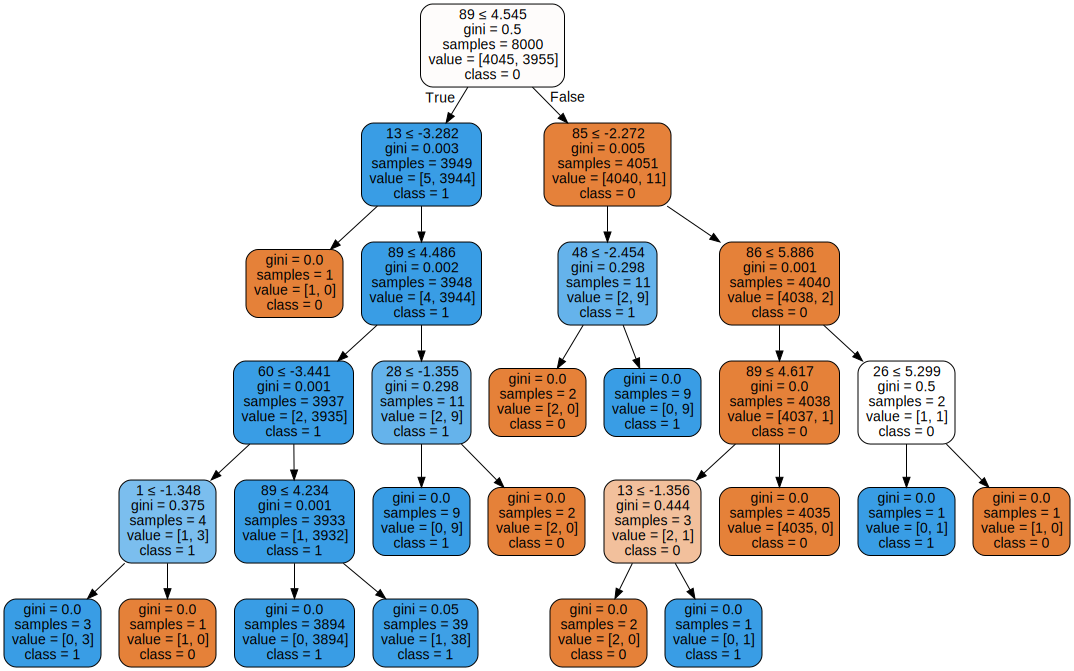

In [24]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model, feature_names=df.columns[:-1], class_names=['0','1'],
                           filled=True, rounded=True, special_characters=True)
# Draw tree
graph = graphviz.Source(dot_data)
graph.render(f'Docs/DTree_noisy_power_per_gate_noisestd={noise_std}', format='png', cleanup=True)
graph